In [1]:
##2.2.1 텐서 다루기

In [2]:
import torch
print(torch.tensor([[1,2],[3,4]]))
print('------------------------')
#print(torch.tensor([[1,2],[3,4]], device="cuda:0")) #GPU가 없다면 오류가 발생하므로 주석 처리하였습니다.
print('------------------------')
print(torch.tensor([[1,2],[3,4]], dtype=torch.float64))

tensor([[1, 2],
        [3, 4]])
------------------------
------------------------
tensor([[1., 2.],
        [3., 4.]], dtype=torch.float64)


In [3]:
temp = torch.tensor([[1,2],[3,4]])
print(temp.numpy())
print('------------------------')
#temp = torch.tensor([[1,2],[3,4]], device="cuda:0") #GPU가 없다면 오류가 발생하므로 주석 처리하였습니다.
temp = torch.tensor([[1,2],[3,4]], device="cpu:0")
print(temp.to("cpu").numpy())

[[1 2]
 [3 4]]
------------------------
[[1 2]
 [3 4]]


In [4]:
temp = torch.FloatTensor([1, 2, 3, 4, 5, 6, 7])
print(temp[0], temp[1], temp[-1])
print('------------------------')
print(temp[2:5], temp[4:-1])

tensor(1.) tensor(2.) tensor(7.)
------------------------
tensor([3., 4., 5.]) tensor([5., 6.])


In [5]:
v = torch.tensor([1, 2, 3])
w = torch.tensor([3, 4, 6])
print(w - v)

tensor([2, 2, 3])


In [6]:
temp = torch.tensor([
    [1, 2], [3, 4]
])

print(temp.shape)
print('------------------------')
print(temp.view(4,1))
print('------------------------')
print(temp.view(-1))
print('------------------------')
print(temp.view(1, -1))
print('------------------------')
print(temp.view(-1, 1))

torch.Size([2, 2])
------------------------
tensor([[1],
        [2],
        [3],
        [4]])
------------------------
tensor([1, 2, 3, 4])
------------------------
tensor([[1, 2, 3, 4]])
------------------------
tensor([[1],
        [2],
        [3],
        [4]])


In [1]:
#2.4 파이토치 코드 맛보기

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
dataset = pd.read_csv(r'../chap02/data/car_evaluation.csv')

In [3]:
dataset.head()

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


<Axes: ylabel='output'>

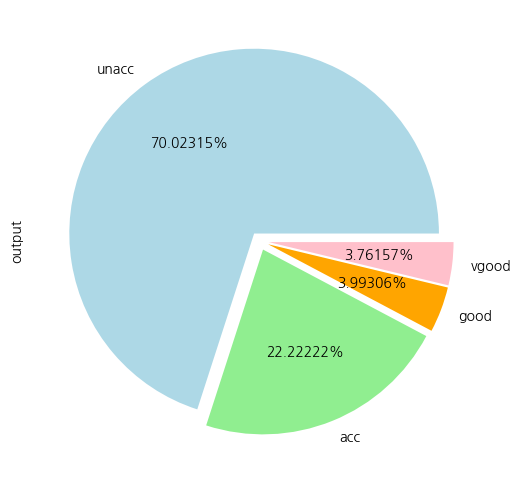

In [4]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
dataset.output.value_counts().plot(kind='pie', autopct='%0.05f%%', colors=['lightblue', 'lightgreen', 'orange', 'pink'], explode=(0.05, 0.05, 0.05,0.05))

In [5]:
categorical_columns = ['price', 'maint', 'doors', 'persons', 'lug_capacity', 'safety']

In [6]:
for category in categorical_columns:
    dataset[category] = dataset[category].astype('category')

In [7]:
price = dataset['price'].cat.codes.values
maint = dataset['maint'].cat.codes.values
doors = dataset['doors'].cat.codes.values
persons = dataset['persons'].cat.codes.values
lug_capacity = dataset['lug_capacity'].cat.codes.values
safety = dataset['safety'].cat.codes.values

categorical_data = np.stack([price, maint, doors, persons, lug_capacity, safety], 1)
categorical_data[:10]

array([[3, 3, 0, 0, 2, 1],
       [3, 3, 0, 0, 2, 2],
       [3, 3, 0, 0, 2, 0],
       [3, 3, 0, 0, 1, 1],
       [3, 3, 0, 0, 1, 2],
       [3, 3, 0, 0, 1, 0],
       [3, 3, 0, 0, 0, 1],
       [3, 3, 0, 0, 0, 2],
       [3, 3, 0, 0, 0, 0],
       [3, 3, 0, 1, 2, 1]], dtype=int8)

In [8]:
categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
categorical_data[:10]

tensor([[3, 3, 0, 0, 2, 1],
        [3, 3, 0, 0, 2, 2],
        [3, 3, 0, 0, 2, 0],
        [3, 3, 0, 0, 1, 1],
        [3, 3, 0, 0, 1, 2],
        [3, 3, 0, 0, 1, 0],
        [3, 3, 0, 0, 0, 1],
        [3, 3, 0, 0, 0, 2],
        [3, 3, 0, 0, 0, 0],
        [3, 3, 0, 1, 2, 1]])

In [9]:
outputs = pd.get_dummies(dataset.output)
outputs = outputs.values
outputs = torch.tensor(outputs)
outputs = torch.argmax(outputs,dim=1)

print(categorical_data.shape)
print(outputs.shape)

torch.Size([1728, 6])
torch.Size([1728])


In [10]:
categorical_column_sizes = [len(dataset[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(4, 2), (4, 2), (4, 2), (3, 2), (3, 2), (3, 2)]


In [11]:
total_records = 1728
test_records = int(total_records * .2)

categorical_train_data = categorical_data[:total_records-test_records]
categorical_test_data = categorical_data[total_records-test_records:total_records]
train_outputs = outputs[:total_records-test_records]
test_outputs = outputs[total_records-test_records:total_records]

In [12]:
print(len(categorical_train_data))
print(len(train_outputs))
print(len(categorical_test_data))
print(len(test_outputs))

1383
1383
345
345


In [13]:
class Model(nn.Module):
    def __init__(self, embedding_size, output_size, layers, p=0.4):
        super().__init__()
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(p)
        
        all_layers = []
        num_categorical_cols = sum((nf for ni, nf in embedding_size))
        input_size = num_categorical_cols 

        for i in layers:
            all_layers.append(nn.Linear(input_size, i))
            all_layers.append(nn.ReLU(inplace=True))
            all_layers.append(nn.BatchNorm1d(i))
            all_layers.append(nn.Dropout(p))
            input_size = i

        all_layers.append(nn.Linear(layers[-1], output_size))
        self.layers = nn.Sequential(*all_layers)

    def forward(self, x_categorical):
        embeddings = []
        for i,e in enumerate(self.all_embeddings):
            print(x_categorical[:,i].shape)
            embeddings.append(e(x_categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embedding_dropout(x)
        x = self.layers(x)
        return x

In [14]:
model = Model(categorical_embedding_sizes, 4, [200,100,50], p=0.4)
print(model)

Model(
  (all_embeddings): ModuleList(
    (0-2): 3 x Embedding(4, 2)
    (3-5): 3 x Embedding(3, 2)
  )
  (embedding_dropout): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=50, out_features=4, bias=True)
  )
)


In [15]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [17]:
epochs = 500
aggregated_losses = []
train_outputs = train_outputs.to(device=device, dtype=torch.int64)
for i in range(epochs):
    i += 1
    y_pred = model(categorical_train_data).to(device)
    single_loss = loss_function(y_pred, train_outputs)
    aggregated_losses.append(single_loss)

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
epoch:   1 loss: 1.62043190
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
torch.Size([1383])
tor

KeyboardInterrupt: 

In [132]:
test_outputs = test_outputs.to(device=device, dtype=torch.int64)
with torch.no_grad():
    y_val = model(categorical_test_data).to(device)
    loss = loss_function(y_val, test_outputs)
print(f'Loss: {loss:.8f}')

Loss: 1.35241508


In [133]:
print(y_val[:5])

tensor([[-0.2304, -1.9195,  3.6269, -1.9777],
        [-2.8696, -2.1009,  3.8487, -1.8935],
        [ 1.3556, -3.0075,  3.5796, -3.1637],
        [-0.2551, -2.1784,  3.0668, -2.1990],
        [ 0.7177, -1.8685,  1.7023, -1.6289]], device='cuda:0')


In [134]:
y_val = np.argmax(y_val.cpu(), axis=1)
print(y_val[:5])

tensor([2, 2, 2, 2, 2])


In [135]:
y_val


tensor([2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2,
        2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0,
        2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0,
        2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
        2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2,
        2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 3, 2, 2, 0, 2, 0, 2, 2, 2, 2,
        2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 3, 2, 0, 2,
        2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 1, 2, 2, 2, 3, 2, 0, 2,
        2, 0, 3, 2, 2, 2, 2, 2, 2, 2, 2,

In [136]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(test_outputs.cpu(),y_val))
print(classification_report(test_outputs.cpu(),y_val))
print(accuracy_score(test_outputs.cpu(), y_val))

[[ 12   0  51   0]
 [ 26   1  16   3]
 [ 14   0 183   0]
 [ 23   0  13   3]]
              precision    recall  f1-score   support

           0       0.16      0.19      0.17        63
           1       1.00      0.02      0.04        46
           2       0.70      0.93      0.80       197
           3       0.50      0.08      0.13        39

    accuracy                           0.58       345
   macro avg       0.59      0.30      0.29       345
weighted avg       0.62      0.58      0.51       345

0.5768115942028985


In [137]:
test_outputs

tensor([2, 2, 2, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 0, 0, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 3, 2, 2, 2, 2, 0, 0, 2, 0, 3,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 0, 2, 0, 3, 2, 0, 0, 2, 0, 3,
        2, 0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 3, 2, 0, 3, 2, 0, 0,
        2, 0, 3, 2, 0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 3, 2, 0, 3,
        2, 0, 0, 2, 0, 3, 2, 0, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 0, 1,
        2, 1, 3, 2, 2, 2, 2, 0, 1, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1,
        2, 0, 1, 2, 1, 3, 2, 0, 1, 2, 1, 3, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 0, 1, 2, 1, 3, 2, 1, 3, 2, 0, 1, 2, 1, 3, 2, 1, 3, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 0, 1, 2, 1, 3, 2, 1, 3, 2, 0, 1, 2, 1, 3, 2, 1, 3, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 0, 1, 2, 1, 3, 2, 2, 2, 2, 0, 1, 2, 1, 3,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 2, 0, 1, 2, 1, 3, 2, 0, 1, 2, 1, 3,
        2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2,